In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from IPython.display import display
%matplotlib inline

## Download KITTI
#### http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo

In [2]:
%%capture

# Download KITTI data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_stereo_flow.zip && unzip data_stereo_flow.zip
!mkdir KITTI12
!mv training KITTI12
!mv testing KITTI12

In [3]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip && unzip data_scene_flow.zip
!mkdir KITTI15
!mv training KITTI15
!mv testing KITTI15

--2020-11-10 23:19:40--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.84
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1681488619 (1.6G) [application/zip]
Saving to: ‘data_scene_flow.zip’

data_scene_flow.zip 100%[===================>]   1.57G  11.7MB/s    in 2m 23s  

2020-11-10 23:22:04 (11.2 MB/s) - ‘data_scene_flow.zip’ saved [1681488619/1681488619]

Archive:  data_scene_flow.zip
   creating: training/
   creating: training/disp_noc_1/
 extracting: training/disp_noc_1/000033_10.png  
 extracting: training/disp_noc_1/000076_10.png  
 extracting: training/disp_noc_1/000194_10.png  
 extracting: training/disp_noc_1/000137_10.png  
 extracting: training/disp_noc_1/000110_10.png  
 extracting: training/disp_noc_1/000188_10.png  
 extracting: training/disp_noc_1/0000

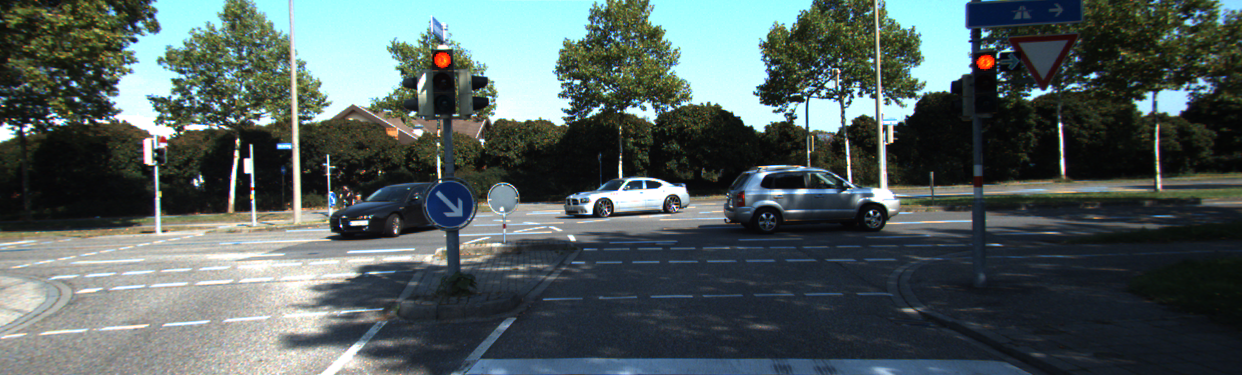

In [4]:
# Visualize KITTI

img_id = 10
img = Image.open("./KITTI15/training/image_2/"+str(img_id).zfill(6)+"_10.png")
display(img)

## Create data loaders

In [5]:
import shutil
import os
for idx in range(194):
  img0_path = "KITTI12/training/colored_0/"+ str(idx).zfill(6) + "_10.png"
  img1_path = "KITTI12/training/colored_1/"+ str(idx).zfill(6) + "_10.png"
  gt_path ="KITTI12/training/disp_occ/"+ str(idx).zfill(6) + "_10.png"

  xidx = idx+200
  shutil.copy(img0_path , "KITTI15/training/image_2/"+ str(xidx).zfill(6) + "_10.png" )
  shutil.copy(img1_path , "KITTI15/training/image_3/"+ str(xidx).zfill(6) + "_10.png" )
  shutil.copy(gt_path , "KITTI15/training/disp_occ_0/"+ str(xidx).zfill(6) + "_10.png" )


In [6]:
class KITTI(Dataset):
    def __init__(self, path, transform=None, train = True):
        self.transform = transform
        self.img0_dir = path + "training/image_2/"
        self.img1_dir = path + "training/image_3/"
        self.gt_dir = path + "training/disp_occ_0/"
        self.train = train
        if train:
          self.size = int(len(os.listdir(self.gt_dir))*0.8)
        else:
          self.size = int(len(os.listdir(self.gt_dir))*0.2)
          self.remainder = int(len(os.listdir(self.gt_dir))*0.8)
          
        self.h = 256
        self.w = 512

    def __len__(self):
        return self.size
    def __getitem__(self, idx):
        if self.train:
          img0_path = self.img0_dir + str(idx).zfill(6) + "_10.png"
          img1_path = self.img1_dir + str(idx).zfill(6) + "_10.png"
          gt_path = self.gt_dir + str(idx).zfill(6) + "_10.png"
          img0 = Image.open(img0_path).convert('RGB')
          img1 = Image.open(img1_path).convert('RGB')
          gt = np.ascontiguousarray(Image.open(gt_path), dtype=np.float32)/256
          w,h  = img0.size
          self.r_h = random.randint(0,h-self.h)
          self.r_w = random.randint(0,w-self.w)
          img0 = img0.crop((self.r_w,self.r_h, self.r_w + self.w,self.r_h + self.h))
          img1 = img1.crop((self.r_w,self.r_h, self.r_w + self.w,self.r_h + self.h))
          gt =  gt[self.r_h:self.r_h+self.h, self.r_w:self.r_w + self.w ]
          if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
          return img0, img1, gt
        else:
          idx += self.remainder
          img0_path = self.img0_dir + str(idx).zfill(6) + "_10.png"
          img1_path = self.img1_dir + str(idx).zfill(6) + "_10.png"
          gt_path = self.gt_dir + str(idx).zfill(6) + "_10.png"
          img0 = Image.open(img0_path).convert('RGB')
          img1 = Image.open(img1_path).convert('RGB')
          w,h  = img0.size
          img0 = img0.crop((w-1232, h-368, w, h))
          img1 = img1.crop((w-1232, h-368, w, h))
          gt = Image.open(gt_path)
          gt = gt.crop((w-1232, h-368, w, h))
          gt = np.ascontiguousarray(gt,dtype=np.float32)/256
          if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
          return img0, img1, gt

In [7]:
normalize = {'mean': [0.485, 0.456, 0.406],
                   'std': [0.229, 0.224, 0.225]}
input_transforms = torchvision.transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(**normalize)])
test_dataset = KITTI('./KITTI15/', transform=input_transforms, train = False)
test_Loader = DataLoader(test_dataset, batch_size= 1, shuffle= False, num_workers= 4, drop_last=False)
print('Test Dataset Size:', len(test_dataset))

Test Dataset Size: 78


In [8]:
train_dataset = KITTI('./KITTI15/', transform=input_transforms,train=True)
train_loader = DataLoader(train_dataset, batch_size=4, pin_memory=True, shuffle=True, num_workers=4)

print('Train Dataset Size:', len(train_dataset))

Train Dataset Size: 315


## Create Basic Model

Here we define some functions and classes from submodule.py

In [9]:
def conv_bn_2d(in_planes, out_planes, kernel_size, stride, pad, dilation):
  return nn.Sequential(
      nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation=dilation, bias=False),
      nn.BatchNorm2d(out_planes)
  )

def conv_bn_3d(in_planes, out_planes, kernel_size, stride, pad):
  return nn.Sequential(
      nn.Conv3d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, padding=pad, stride=stride, bias=False),
      nn.BatchNorm3d(out_planes)
  )

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, out_planes, stride, downsample, pad, dilation):
    super(BasicBlock, self).__init__()
    self.downsample = downsample
    self.stride = stride
    self.conv1 = nn.Sequential(
        conv_bn_2d(in_planes, out_planes, 3, stride, pad, dilation),
        nn.ReLU(inplace=True)
    )
    self.conv2 = conv_bn_2d(out_planes, out_planes, 3, 1, pad, dilation)

  def forward(self, x):
    out = self.conv2(self.conv1(x))

    if self.downsample is not None:
      x = self.downsample(x)
    out += x

    return out

class MatchShifted(nn.Module):
  def __init__(self):
    super(MatchShifted, self).__init__()

  def forward(self, left, right, shift):
    batch, filters, height, width = left.size()
    shifted_left  = F.pad(torch.index_select(left,  3, Variable(torch.LongTensor([i for i in range(shift,width)])).cuda()),(shift,0,0,0))
    shifted_right = F.pad(torch.index_select(right, 3, Variable(torch.LongTensor([i for i in range(width-shift)])).cuda()),(shift,0,0,0))
    out = torch.cat((shifted_left,shifted_right),1).view(batch,filters*2,1,height,width)

    return out

class DisparityRegression(nn.Module):
  def __init__(self, max_disp):
    super(DisparityRegression, self).__init__()
    self.disp = Variable(torch.Tensor(np.reshape(np.array(range(max_disp)),[1,max_disp,1,1])).cuda(), requires_grad=False)

  def forward(self, x):
    disp = self.disp.repeat(x.size()[0],1,x.size()[2],x.size()[3])
    out = torch.sum(x*disp,1)

    return out

class FeatureExtraction(nn.Module):
    def __init__(self):
        super(FeatureExtraction, self).__init__()
        self.inplanes = 32
        self.firstconv = nn.Sequential(conv_bn_2d(3, 32, 3, 2, 1, 1),
                                       nn.ReLU(inplace=True),
                                       conv_bn_2d(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True),
                                       conv_bn_2d(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True))

        self.layer1 = self._make_layer(BasicBlock, 32, 3, 1,1,1)
        self.layer2 = self._make_layer(BasicBlock, 64, 16, 2,1,1) 
        self.layer3 = self._make_layer(BasicBlock, 128, 3, 1,1,1)
        self.layer4 = self._make_layer(BasicBlock, 128, 3, 1,1,2)

        self.branch1 = nn.Sequential(nn.AvgPool2d((64, 64), stride=(64,64)),
                                     conv_bn_2d(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch2 = nn.Sequential(nn.AvgPool2d((32, 32), stride=(32,32)),
                                     conv_bn_2d(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch3 = nn.Sequential(nn.AvgPool2d((16, 16), stride=(16,16)),
                                     conv_bn_2d(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch4 = nn.Sequential(nn.AvgPool2d((8, 8), stride=(8,8)),
                                     conv_bn_2d(128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.lastconv = nn.Sequential(conv_bn_2d(320, 128, 3, 1, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, kernel_size=1, padding=0, stride = 1, bias=False))

    def _make_layer(self, block, planes, blocks, stride, pad, dilation):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
           downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, pad, dilation))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,1,None,pad,dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        output      = self.firstconv(x)
        output      = self.layer1(output)
        output_raw  = self.layer2(output)
        output      = self.layer3(output_raw)
        output_skip = self.layer4(output)


        output_branch1 = self.branch1(output_skip)
        output_branch1 = F.upsample(output_branch1, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch2 = self.branch2(output_skip)
        output_branch2 = F.upsample(output_branch2, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch3 = self.branch3(output_skip)
        output_branch3 = F.upsample(output_branch3, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_branch4 = self.branch4(output_skip)
        output_branch4 = F.upsample(output_branch4, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')

        output_feature = torch.cat((output_raw, output_skip, output_branch4, output_branch3, output_branch2, output_branch1), 1)
        output_feature = self.lastconv(output_feature)

        return output_feature

In [10]:
class PSMNet(nn.Module):
  def __init__(self, max_disp):
    super(PSMNet, self).__init__()
    self.maxdisp = max_disp
    self.feature_extraction = FeatureExtraction()

    self.dres0 = nn.Sequential(
      conv_bn_3d(64, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn_3d(32, 32, 3, 1, 1),
      nn.ReLU(inplace=True)
    )
    self.dres1 = nn.Sequential(
      conv_bn_3d(32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn_3d(32, 32, 3, 1, 1),
    )
    self.dres2 = nn.Sequential(
      conv_bn_3d(32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn_3d(32, 32, 3, 1, 1)
    )
    self.dres3 = nn.Sequential(
      conv_bn_3d(32, 32, 3, 1, 1),
      nn.ReLU(inplace=True), 
      conv_bn_3d(32, 32, 3, 1, 1)
    )
    self.dres4 = nn.Sequential(
      conv_bn_3d(32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn_3d(32, 32, 3, 1, 1)
    )
    self.classify = nn.Sequential(
      conv_bn_3d(32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1, bias=False)
    )

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
      elif isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.bias.data.zero_()

  def forward(self, left, right):
    ref_img_fea = self.feature_extraction(left)
    target_img_fea  = self.feature_extraction(right)

    cost = Variable(torch.FloatTensor(ref_img_fea.size()[0], ref_img_fea.size()[1]*2, self.maxdisp//4,  ref_img_fea.size()[2],  ref_img_fea.size()[3]).zero_(), volatile= not self.training).cuda()

    for i in range(self.maxdisp//4):
      if i > 0 :
        cost[:, :ref_img_fea.size()[1], i, :,i:] = ref_img_fea[:,:,:,i:]
        cost[:, ref_img_fea.size()[1]:, i, :,i:] = target_img_fea[:,:,:,:-i]
      else:
        cost[:, :ref_img_fea.size()[1], i, :,:] = ref_img_fea
        cost[:, ref_img_fea.size()[1]:, i, :,:] = target_img_fea
    cost = cost.contiguous()

    cost0 = self.dres0(cost)
    cost0 = self.dres1(cost0) + cost0
    cost0 = self.dres2(cost0) + cost0 
    cost0 = self.dres3(cost0) + cost0 
    cost0 = self.dres4(cost0) + cost0

    cost = self.classify(cost0)
    cost = F.upsample(cost, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
    cost = torch.squeeze(cost,1)
    pred = F.softmax(cost)
    pred = DisparityRegression(self.maxdisp)(pred)

    return pred

Here we implement the basic.py

## Train Model

In [20]:
# Define network and training parameters
torch.cuda.empty_cache()
model = PSMNet(192)
device = torch.device("cuda")
model.to(device)
print(model)

num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

PSMNet(
  (feature_extraction): SPPModule(
    (first_conv): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU(inplace=True)
      (2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): ReLU(inplace=True)
      (4): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): ReLU(inplace=True)
      (6): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [21]:
def Test_Acc(model2,test_loader):
  def test(imgL,imgR,disp_true):

        model2.eval()
        imgL   = Variable(torch.FloatTensor(imgL))
        imgR   = Variable(torch.FloatTensor(imgR))   
        imgL, imgR = imgL.cuda(), imgR.cuda()

        with torch.no_grad():
            output3 = model2(imgL,imgR)

        pred_disp = output3.data.cpu()
        true_disp = disp_true.clone()
        
        array = np.zeros(true_disp.shape)
        array[true_disp>0] = 1

        greater_than_one = len(array[array==1])

        disp_true = np.abs(true_disp-pred_disp.numpy())
        disp_true = disp_true*array
        error = len(disp_true[disp_true>3])

        return float(error)/float(greater_than_one)

  Error = []
  for i, (imgL, imgR, disp_L) in enumerate(test_Loader):
        Error.append(1-test(imgL,imgR,disp_L))

  print(f'Final Accuracy: {np.mean(np.array(Error))}')
  return np.mean(np.array(Error))

In [22]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params,pytorch_total_trainable_params)

3147968 3147968


In [ ]:
# Train loop
import time
import numpy as np
import pandas as pd
from google.colab import files
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
model.train()
avg_loss = []
start_time = time.time()
Acc = []
for epoch in range(num_epochs):
    total_train_loss = 0
    for i, (imgL, imgR, disp_L) in enumerate(train_loader):
      imgL = Variable(torch.FloatTensor(imgL)).to(device)
      imgR = Variable(torch.FloatTensor(imgR)).to(device)   
      disp_L = Variable(torch.FloatTensor(disp_L)).to(device)

      mask = (disp_L > 0)
      mask.detach_()

      optimizer.zero_grad()
      out = model(imgL, imgR)
      out = torch.squeeze(out, 1)
      loss = F.smooth_l1_loss(out[mask], disp_L[mask], size_average=True)

      loss.backward()
      optimizer.step()
      avg_loss.append(loss.item())
      if i%5==0:
        print('Epoch: {0}, Iter: {1}, Training Loss: {2}'.format(epoch, i, loss))

      total_train_loss += loss.item()

      torch.cuda.empty_cache()
      del imgL
      del imgR
      del disp_L
      del out
      del loss


    scheduler.step(np.mean(avg_loss))
    print(f'Scheduler saw loss: {np.mean(avg_loss)}')
    print(f'Time: {(time.time()-start_time)/60} \n') 
    model.eval()
    Acc.append(Test_Acc(model,test_Loader))
    
    model.train()
    if epoch % 10 == 0:
      print(f'Saving the model at Epoch: {epoch}, Average Loss: {np.mean(avg_loss)} as Model_V2_Epoch_{epoch}')
      torch.save(model.state_dict(), f'Model_V2_Epoch_{epoch}.pt')
      #files.download(f'Model_V2_Epoch_{epoch}.pt')
      index = [f'Epoch {i}' for i in range(len(Acc))]
      Accuracy_Values = {f'Test Accuracy':Acc}
      df_accuracy = pd.DataFrame(Accuracy_Values,index=index)
      df_accuracy.to_csv(f'Accuracy_Values_Epoch_{epoch}.csv')
      files.download(f'Accuracy_Values_Epoch_{epoch}.csv')

    avg_loss = []



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, Iter: 0, Training Loss: 2.2974841594696045
Epoch: 0, Iter: 5, Training Loss: 1.9594402313232422
Epoch: 0, Iter: 10, Training Loss: 2.5056543350219727
Epoch: 0, Iter: 15, Training Loss: 1.4662728309631348
Epoch: 0, Iter: 20, Training Loss: 1.99164879322052
Epoch: 0, Iter: 25, Training Loss: 1.7235766649246216
Epoch: 0, Iter: 30, Training Loss: 1.884227991104126
Epoch: 0, Iter: 35, Training Loss: 1.6355501413345337
Epoch: 0, Iter: 40, Training Loss: 1.3334304094314575
Epoch: 0, Iter: 45, Training Loss: 1.079014778137207
Epoch: 0, Iter: 50, Training Loss: 1.733330249786377
Epoch: 0, Iter: 55, Training Loss: 4.3972578048706055
Epoch: 0, Iter: 60, Training Loss: 1.337613582611084
Epoch: 0, Iter: 65, Training Loss: 1.3372104167938232
Epoch: 0, Iter: 70, Training Loss: 1.5084820985794067
Epoch: 0, Iter: 75, Training Loss: 1.6629490852355957
Scheduler saw loss: 1.9258833655828163
Time: 6.333991404374441 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Final Accuracy: 0.8274457309661386
Saving the model at Epoch: 0, Average Loss: 1.9258833655828163 as Model_V2_Epoch_0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch: 1, Iter: 0, Training Loss: 1.6559768915176392
Epoch: 1, Iter: 5, Training Loss: 1.1633516550064087
Epoch: 1, Iter: 10, Training Loss: 1.1576573848724365
Epoch: 1, Iter: 15, Training Loss: 1.890041708946228
Epoch: 1, Iter: 20, Training Loss: 1.869618535041809
Epoch: 1, Iter: 25, Training Loss: 1.1385700702667236
Epoch: 1, Iter: 30, Training Loss: 1.1886229515075684
Epoch: 1, Iter: 35, Training Loss: 1.1519598960876465
Epoch: 1, Iter: 40, Training Loss: 3.3640236854553223
Epoch: 1, Iter: 45, Training Loss: 1.471907615661621
Epoch: 1, Iter: 50, Training Loss: 4.616444110870361
Epoch: 1, Iter: 55, Training Loss: 1.5219082832336426
Epoch: 1, Iter: 60, Training Loss: 1.4479118585586548
Epoch: 1, Iter: 65, Training Loss: 1.5161199569702148
Epoch: 1, Iter: 70, Training Loss: 1.661020278930664
Epoch: 1, Iter: 75, Training Loss: 1.6258548498153687
Scheduler saw loss: 1.661014805111704
Time: 13.214179980754853 

Final Accuracy: 0.8421328763741304
Epoch: 2, Iter: 0, Training Loss: 0.9459788

In [ ]:
torch.save(model.state_dict(), f'model_V4_Modified_Epoch_{epoch}.pt')

In [ ]:
model2 = PSMNet(192)
model2.load_state_dict(torch.load('model_V1_Epoch_86.pt'));
model2.eval()
device = torch.device("cuda")
model2.to(device)

PSMNet(
  (feature_extraction): FeatureExtraction(
    (firstconv): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU(inplace=True)
      (2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): ReLU(inplace=True)
      (4): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
!nvidia-smi

Mon Nov  9 14:48:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    40W / 250W |  10681MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------